In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d bulentsiyah/semantic-drone-dataset
# Installing Kaggle package, set up API credentials, and download the "semantic-drone-dataset" from Kaggle.

Dataset URL: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset
License(s): other
100% 3.89G/3.89G [00:40<00:00, 130MB/s]
100% 3.89G/3.89G [00:40<00:00, 102MB/s]


In [2]:
!unzip /content/semantic-drone-dataset.zip

Archive:  /content/semantic-drone-dataset.zip
  inflating: RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/006.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/008.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/011.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/013.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/014.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/015.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/016.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/018.png  
  inflating: RGB

In [3]:
# Importing necessary libraries
import cv2
import numpy as np
import os
import pandas as pd

from tqdm import tqdm
from glob import glob
from albumentations import RandomCrop, HorizontalFlip, VerticalFlip

from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from keras.utils import plot_model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback

In [4]:
# Data Augmentation
# Original images have a resolution of 6000x4000px. We've chosen to resize them to 1536x1024px while maintaining the original aspect ratio.

# Function to create directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Function to augment images and masks and save them to specified directory
def augment_data(images, masks, save_path, augment=True):
    H = 1024
    W = 1536

    # Iterating through each pair of original image and mask
    for x,y in tqdm(zip(images, masks), total=len(images)):
        print("x:", x)
        print("y:", y)
        name = x.split("/")[-1].split(".")
        print("name:", name)
        image_name = name[0]
        image_extn = name[1]

        name = y.split("/")[-1].split(".")
        mask_name = name[0]
        mask_extn = name[1]

        # Reading and resizing original image
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = cv2.resize(x, (W, H))
        y = cv2.imread(y, cv2.IMREAD_COLOR)
        y = cv2.resize(y, (W, H))

        if augment == True:
            # Augmenting data if flag is set to True
            aug = RandomCrop(int(2*H/3), int(2*W/3), always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = HorizontalFlip(always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = VerticalFlip(always_apply=False, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            # Saving augmented images and masks
            save_images = [x, x1, x2, x3]
            save_masks = [y, y1, y2, y3]

        else:
            # If augmentation is not required, keep original images and masks
            save_images = [x]
            save_masks = [y]

        idx = 0
        for i, m in zip(save_images, save_masks):
            i = cv2.resize(i, (W, H))
            m = cv2.resize(m, (W, H))

            tmp_img_name = f"{image_name}_{idx}.{image_extn}"
            tmp_msk_name = f"{mask_name}_{idx}.{mask_extn}"

            image_path = os.path.join(save_path, "images", tmp_img_name)
            mask_path = os.path.join(save_path, "masks", tmp_msk_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx+=1

# Path to the original dataset
path = "/content/dataset/semantic_drone_dataset"

# Getting paths to original images and masks
images = sorted(glob(os.path.join(path, "original_images/*")))
masks = sorted(glob(os.path.join(path, "label_images_semantic/*")))

print(f"Original images:  {len(images)} - Original masks: {len(masks)}")

# Creating directories to save augmented images and masks
create_dir("./new_data/images/")
create_dir("./new_data/masks/")

save_path = "./new_data/"

# Augmenting data
augment_data(images, masks, save_path, augment=True)

images = sorted(glob(os.path.join(save_path, "images/*")))
masks = sorted(glob(os.path.join(save_path, "masks/*")))
print(f"Augmented images:  {len(images)} - Augmented masks: {len(masks)}")

Original images:  400 - Original masks: 400


  0%|          | 0/400 [00:00<?, ?it/s]

x: /content/dataset/semantic_drone_dataset/original_images/000.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/000.png
name: ['000', 'jpg']


  0%|          | 1/400 [00:01<12:00,  1.81s/it]

x: /content/dataset/semantic_drone_dataset/original_images/001.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/001.png
name: ['001', 'jpg']


  0%|          | 2/400 [00:04<15:08,  2.28s/it]

x: /content/dataset/semantic_drone_dataset/original_images/002.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/002.png
name: ['002', 'jpg']


  1%|          | 3/400 [00:07<16:06,  2.43s/it]

x: /content/dataset/semantic_drone_dataset/original_images/003.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/003.png
name: ['003', 'jpg']


  1%|          | 4/400 [00:08<14:44,  2.23s/it]

x: /content/dataset/semantic_drone_dataset/original_images/004.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/004.png
name: ['004', 'jpg']


  1%|▏         | 5/400 [00:11<14:28,  2.20s/it]

x: /content/dataset/semantic_drone_dataset/original_images/005.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/005.png
name: ['005', 'jpg']


  2%|▏         | 6/400 [00:12<11:50,  1.80s/it]

x: /content/dataset/semantic_drone_dataset/original_images/006.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/006.png
name: ['006', 'jpg']


  2%|▏         | 7/400 [00:13<10:11,  1.56s/it]

x: /content/dataset/semantic_drone_dataset/original_images/008.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/008.png
name: ['008', 'jpg']


  2%|▏         | 8/400 [00:14<09:05,  1.39s/it]

x: /content/dataset/semantic_drone_dataset/original_images/011.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/011.png
name: ['011', 'jpg']


  2%|▏         | 9/400 [00:15<08:11,  1.26s/it]

x: /content/dataset/semantic_drone_dataset/original_images/013.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/013.png
name: ['013', 'jpg']


  2%|▎         | 10/400 [00:16<08:22,  1.29s/it]

x: /content/dataset/semantic_drone_dataset/original_images/014.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/014.png
name: ['014', 'jpg']


  3%|▎         | 11/400 [00:17<08:40,  1.34s/it]

x: /content/dataset/semantic_drone_dataset/original_images/015.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/015.png
name: ['015', 'jpg']


  3%|▎         | 12/400 [00:19<08:14,  1.27s/it]

x: /content/dataset/semantic_drone_dataset/original_images/016.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/016.png
name: ['016', 'jpg']


  3%|▎         | 13/400 [00:20<07:35,  1.18s/it]

x: /content/dataset/semantic_drone_dataset/original_images/018.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/018.png
name: ['018', 'jpg']


  4%|▎         | 14/400 [00:21<07:17,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/019.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/019.png
name: ['019', 'jpg']


  4%|▍         | 15/400 [00:22<07:00,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/021.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/021.png
name: ['021', 'jpg']


  4%|▍         | 16/400 [00:23<06:42,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/022.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/022.png
name: ['022', 'jpg']


  4%|▍         | 17/400 [00:24<06:33,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/023.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/023.png
name: ['023', 'jpg']


  4%|▍         | 18/400 [00:25<06:31,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/026.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/026.png
name: ['026', 'jpg']


  5%|▍         | 19/400 [00:26<06:24,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/028.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/028.png
name: ['028', 'jpg']


  5%|▌         | 20/400 [00:27<06:22,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/031.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/031.png
name: ['031', 'jpg']


  5%|▌         | 21/400 [00:28<06:19,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/035.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/035.png
name: ['035', 'jpg']


  6%|▌         | 22/400 [00:29<07:04,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/038.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/038.png
name: ['038', 'jpg']


  6%|▌         | 23/400 [00:30<07:37,  1.21s/it]

x: /content/dataset/semantic_drone_dataset/original_images/040.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/040.png
name: ['040', 'jpg']


  6%|▌         | 24/400 [00:31<07:21,  1.17s/it]

x: /content/dataset/semantic_drone_dataset/original_images/041.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/041.png
name: ['041', 'jpg']


  6%|▋         | 25/400 [00:32<06:59,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/042.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/042.png
name: ['042', 'jpg']


  6%|▋         | 26/400 [00:33<06:38,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/043.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/043.png
name: ['043', 'jpg']


  7%|▋         | 27/400 [00:34<06:30,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/044.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/044.png
name: ['044', 'jpg']


  7%|▋         | 28/400 [00:35<06:24,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/045.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/045.png
name: ['045', 'jpg']


  7%|▋         | 29/400 [00:36<06:19,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/047.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/047.png
name: ['047', 'jpg']


  8%|▊         | 30/400 [00:37<06:14,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/049.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/049.png
name: ['049', 'jpg']


  8%|▊         | 31/400 [00:38<06:13,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/051.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/051.png
name: ['051', 'jpg']


  8%|▊         | 32/400 [00:39<06:09,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/052.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/052.png
name: ['052', 'jpg']


  8%|▊         | 33/400 [00:40<06:08,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/053.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/053.png
name: ['053', 'jpg']


  8%|▊         | 34/400 [00:42<06:46,  1.11s/it]

x: /content/dataset/semantic_drone_dataset/original_images/055.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/055.png
name: ['055', 'jpg']


  9%|▉         | 35/400 [00:43<07:14,  1.19s/it]

x: /content/dataset/semantic_drone_dataset/original_images/056.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/056.png
name: ['056', 'jpg']


  9%|▉         | 36/400 [00:44<06:51,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/057.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/057.png
name: ['057', 'jpg']


  9%|▉         | 37/400 [00:45<06:36,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/058.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/058.png
name: ['058', 'jpg']


 10%|▉         | 38/400 [00:46<06:27,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/059.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/059.png
name: ['059', 'jpg']


 10%|▉         | 39/400 [00:47<06:17,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/060.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/060.png
name: ['060', 'jpg']


 10%|█         | 40/400 [00:48<06:10,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/062.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/062.png
name: ['062', 'jpg']


 10%|█         | 41/400 [00:49<06:03,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/063.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/063.png
name: ['063', 'jpg']


 10%|█         | 42/400 [00:50<05:55,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/065.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/065.png
name: ['065', 'jpg']


 11%|█         | 43/400 [00:51<05:53,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/068.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/068.png
name: ['068', 'jpg']


 11%|█         | 44/400 [00:52<05:47,  1.03it/s]

x: /content/dataset/semantic_drone_dataset/original_images/070.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/070.png
name: ['070', 'jpg']


 11%|█▏        | 45/400 [00:53<05:44,  1.03it/s]

x: /content/dataset/semantic_drone_dataset/original_images/071.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/071.png
name: ['071', 'jpg']


 12%|█▏        | 46/400 [00:54<06:23,  1.08s/it]

x: /content/dataset/semantic_drone_dataset/original_images/073.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/073.png
name: ['073', 'jpg']


 12%|█▏        | 47/400 [00:56<06:50,  1.16s/it]

x: /content/dataset/semantic_drone_dataset/original_images/074.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/074.png
name: ['074', 'jpg']


 12%|█▏        | 48/400 [00:57<06:31,  1.11s/it]

x: /content/dataset/semantic_drone_dataset/original_images/075.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/075.png
name: ['075', 'jpg']


 12%|█▏        | 49/400 [00:58<06:13,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/077.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/077.png
name: ['077', 'jpg']


 12%|█▎        | 50/400 [00:58<05:59,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/078.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/078.png
name: ['078', 'jpg']


 13%|█▎        | 51/400 [00:59<05:53,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/079.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/079.png
name: ['079', 'jpg']


 13%|█▎        | 52/400 [01:00<05:50,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/080.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/080.png
name: ['080', 'jpg']


 13%|█▎        | 53/400 [01:01<05:44,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/081.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/081.png
name: ['081', 'jpg']


 14%|█▎        | 54/400 [01:02<05:44,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/083.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/083.png
name: ['083', 'jpg']


 14%|█▍        | 55/400 [01:03<05:41,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/086.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/086.png
name: ['086', 'jpg']


 14%|█▍        | 56/400 [01:04<05:39,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/088.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/088.png
name: ['088', 'jpg']


 14%|█▍        | 57/400 [01:05<05:54,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/089.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/089.png
name: ['089', 'jpg']


 14%|█▍        | 58/400 [01:07<06:33,  1.15s/it]

x: /content/dataset/semantic_drone_dataset/original_images/092.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/092.png
name: ['092', 'jpg']


 15%|█▍        | 59/400 [01:08<06:43,  1.18s/it]

x: /content/dataset/semantic_drone_dataset/original_images/095.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/095.png
name: ['095', 'jpg']


 15%|█▌        | 60/400 [01:09<06:22,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/098.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/098.png
name: ['098', 'jpg']


 15%|█▌        | 61/400 [01:10<06:08,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/099.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/099.png
name: ['099', 'jpg']


 16%|█▌        | 62/400 [01:11<06:02,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/100.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/100.png
name: ['100', 'jpg']


 16%|█▌        | 63/400 [01:12<05:53,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/101.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/101.png
name: ['101', 'jpg']


 16%|█▌        | 64/400 [01:13<05:44,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/102.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/102.png
name: ['102', 'jpg']


 16%|█▋        | 65/400 [01:14<05:40,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/103.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/103.png
name: ['103', 'jpg']


 16%|█▋        | 66/400 [01:15<05:38,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/104.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/104.png
name: ['104', 'jpg']


 17%|█▋        | 67/400 [01:16<05:36,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/106.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/106.png
name: ['106', 'jpg']


 17%|█▋        | 68/400 [01:17<05:37,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/107.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/107.png
name: ['107', 'jpg']


 17%|█▋        | 69/400 [01:18<05:49,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/109.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/109.png
name: ['109', 'jpg']


 18%|█▊        | 70/400 [01:20<06:27,  1.17s/it]

x: /content/dataset/semantic_drone_dataset/original_images/110.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/110.png
name: ['110', 'jpg']


 18%|█▊        | 71/400 [01:21<06:23,  1.17s/it]

x: /content/dataset/semantic_drone_dataset/original_images/111.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/111.png
name: ['111', 'jpg']


 18%|█▊        | 72/400 [01:22<06:05,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/112.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/112.png
name: ['112', 'jpg']


 18%|█▊        | 73/400 [01:23<05:50,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/113.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/113.png
name: ['113', 'jpg']


 18%|█▊        | 74/400 [01:24<05:41,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/116.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/116.png
name: ['116', 'jpg']


 19%|█▉        | 75/400 [01:25<05:31,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/117.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/117.png
name: ['117', 'jpg']


 19%|█▉        | 76/400 [01:26<05:37,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/118.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/118.png
name: ['118', 'jpg']


 19%|█▉        | 77/400 [01:27<05:31,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/119.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/119.png
name: ['119', 'jpg']


 20%|█▉        | 78/400 [01:28<05:23,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/120.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/120.png
name: ['120', 'jpg']


 20%|█▉        | 79/400 [01:29<05:16,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/121.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/121.png
name: ['121', 'jpg']


 20%|██        | 80/400 [01:30<05:13,  1.02it/s]

x: /content/dataset/semantic_drone_dataset/original_images/122.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/122.png
name: ['122', 'jpg']


 20%|██        | 81/400 [01:31<05:29,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/123.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/123.png
name: ['123', 'jpg']


 20%|██        | 82/400 [01:32<06:08,  1.16s/it]

x: /content/dataset/semantic_drone_dataset/original_images/124.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/124.png
name: ['124', 'jpg']


 21%|██        | 83/400 [01:34<06:11,  1.17s/it]

x: /content/dataset/semantic_drone_dataset/original_images/126.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/126.png
name: ['126', 'jpg']


 21%|██        | 84/400 [01:35<05:52,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/128.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/128.png
name: ['128', 'jpg']


 21%|██▏       | 85/400 [01:36<05:39,  1.08s/it]

x: /content/dataset/semantic_drone_dataset/original_images/130.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/130.png
name: ['130', 'jpg']


 22%|██▏       | 86/400 [01:37<05:31,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/133.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/133.png
name: ['133', 'jpg']


 22%|██▏       | 87/400 [01:38<05:23,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/134.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/134.png
name: ['134', 'jpg']


 22%|██▏       | 88/400 [01:39<05:17,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/135.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/135.png
name: ['135', 'jpg']


 22%|██▏       | 89/400 [01:40<05:09,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/136.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/136.png
name: ['136', 'jpg']


 22%|██▎       | 90/400 [01:41<05:39,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/137.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/137.png
name: ['137', 'jpg']


 23%|██▎       | 91/400 [01:43<06:50,  1.33s/it]

x: /content/dataset/semantic_drone_dataset/original_images/138.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/138.png
name: ['138', 'jpg']


 23%|██▎       | 92/400 [01:44<06:42,  1.31s/it]

x: /content/dataset/semantic_drone_dataset/original_images/139.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/139.png
name: ['139', 'jpg']


 23%|██▎       | 93/400 [01:45<06:54,  1.35s/it]

x: /content/dataset/semantic_drone_dataset/original_images/140.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/140.png
name: ['140', 'jpg']


 24%|██▎       | 94/400 [01:46<06:24,  1.26s/it]

x: /content/dataset/semantic_drone_dataset/original_images/141.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/141.png
name: ['141', 'jpg']


 24%|██▍       | 95/400 [01:47<05:58,  1.17s/it]

x: /content/dataset/semantic_drone_dataset/original_images/145.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/145.png
name: ['145', 'jpg']


 24%|██▍       | 96/400 [01:48<05:40,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/146.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/146.png
name: ['146', 'jpg']


 24%|██▍       | 97/400 [01:49<05:25,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/147.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/147.png
name: ['147', 'jpg']


 24%|██▍       | 98/400 [01:50<05:19,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/148.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/148.png
name: ['148', 'jpg']


 25%|██▍       | 99/400 [01:51<05:11,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/149.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/149.png
name: ['149', 'jpg']


 25%|██▌       | 100/400 [01:52<05:08,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/150.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/150.png
name: ['150', 'jpg']


 25%|██▌       | 101/400 [01:53<05:05,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/153.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/153.png
name: ['153', 'jpg']


 26%|██▌       | 102/400 [01:54<05:02,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/154.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/154.png
name: ['154', 'jpg']


 26%|██▌       | 103/400 [01:55<04:55,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/155.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/155.png
name: ['155', 'jpg']


 26%|██▌       | 104/400 [01:57<05:29,  1.11s/it]

x: /content/dataset/semantic_drone_dataset/original_images/156.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/156.png
name: ['156', 'jpg']


 26%|██▋       | 105/400 [01:58<05:47,  1.18s/it]

x: /content/dataset/semantic_drone_dataset/original_images/157.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/157.png
name: ['157', 'jpg']


 26%|██▋       | 106/400 [01:59<05:28,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/158.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/158.png
name: ['158', 'jpg']


 27%|██▋       | 107/400 [02:00<05:13,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/159.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/159.png
name: ['159', 'jpg']


 27%|██▋       | 108/400 [02:01<05:02,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/160.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/160.png
name: ['160', 'jpg']


 27%|██▋       | 109/400 [02:02<04:53,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/161.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/161.png
name: ['161', 'jpg']


 28%|██▊       | 110/400 [02:03<04:56,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/162.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/162.png
name: ['162', 'jpg']


 28%|██▊       | 111/400 [02:04<04:53,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/163.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/163.png
name: ['163', 'jpg']


 28%|██▊       | 112/400 [02:05<04:49,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/164.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/164.png
name: ['164', 'jpg']


 28%|██▊       | 113/400 [02:06<04:46,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/165.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/165.png
name: ['165', 'jpg']


 28%|██▊       | 114/400 [02:07<04:45,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/166.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/166.png
name: ['166', 'jpg']


 29%|██▉       | 115/400 [02:08<04:44,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/167.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/167.png
name: ['167', 'jpg']


 29%|██▉       | 116/400 [02:09<05:22,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/170.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/170.png
name: ['170', 'jpg']


 29%|██▉       | 117/400 [02:11<05:33,  1.18s/it]

x: /content/dataset/semantic_drone_dataset/original_images/171.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/171.png
name: ['171', 'jpg']


 30%|██▉       | 118/400 [02:12<05:16,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/172.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/172.png
name: ['172', 'jpg']


 30%|██▉       | 119/400 [02:13<04:59,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/173.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/173.png
name: ['173', 'jpg']


 30%|███       | 120/400 [02:14<04:51,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/174.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/174.png
name: ['174', 'jpg']


 30%|███       | 121/400 [02:15<04:45,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/175.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/175.png
name: ['175', 'jpg']


 30%|███       | 122/400 [02:16<04:41,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/176.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/176.png
name: ['176', 'jpg']


 31%|███       | 123/400 [02:17<04:42,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/177.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/177.png
name: ['177', 'jpg']


 31%|███       | 124/400 [02:18<04:39,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/178.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/178.png
name: ['178', 'jpg']


 31%|███▏      | 125/400 [02:19<04:35,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/179.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/179.png
name: ['179', 'jpg']


 32%|███▏      | 126/400 [02:20<04:31,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/180.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/180.png
name: ['180', 'jpg']


 32%|███▏      | 127/400 [02:21<04:42,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/181.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/181.png
name: ['181', 'jpg']


 32%|███▏      | 128/400 [02:23<06:20,  1.40s/it]

x: /content/dataset/semantic_drone_dataset/original_images/182.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/182.png
name: ['182', 'jpg']


 32%|███▏      | 129/400 [02:24<05:52,  1.30s/it]

x: /content/dataset/semantic_drone_dataset/original_images/185.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/185.png
name: ['185', 'jpg']


 32%|███▎      | 130/400 [02:25<05:23,  1.20s/it]

x: /content/dataset/semantic_drone_dataset/original_images/186.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/186.png
name: ['186', 'jpg']


 33%|███▎      | 131/400 [02:26<05:04,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/188.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/188.png
name: ['188', 'jpg']


 33%|███▎      | 132/400 [02:27<04:49,  1.08s/it]

x: /content/dataset/semantic_drone_dataset/original_images/190.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/190.png
name: ['190', 'jpg']


 33%|███▎      | 133/400 [02:28<04:41,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/192.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/192.png
name: ['192', 'jpg']


 34%|███▎      | 134/400 [02:29<04:39,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/193.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/193.png
name: ['193', 'jpg']


 34%|███▍      | 135/400 [02:30<04:35,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/194.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/194.png
name: ['194', 'jpg']


 34%|███▍      | 136/400 [02:31<04:28,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/195.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/195.png
name: ['195', 'jpg']


 34%|███▍      | 137/400 [02:32<04:24,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/198.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/198.png
name: ['198', 'jpg']


 34%|███▍      | 138/400 [02:33<04:21,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/199.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/199.png
name: ['199', 'jpg']


 35%|███▍      | 139/400 [02:34<04:37,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/200.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/200.png
name: ['200', 'jpg']


 35%|███▌      | 140/400 [02:36<05:10,  1.19s/it]

x: /content/dataset/semantic_drone_dataset/original_images/202.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/202.png
name: ['202', 'jpg']


 35%|███▌      | 141/400 [02:37<04:57,  1.15s/it]

x: /content/dataset/semantic_drone_dataset/original_images/204.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/204.png
name: ['204', 'jpg']


 36%|███▌      | 142/400 [02:38<04:42,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/206.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/206.png
name: ['206', 'jpg']


 36%|███▌      | 143/400 [02:39<04:31,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/207.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/207.png
name: ['207', 'jpg']


 36%|███▌      | 144/400 [02:40<04:27,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/208.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/208.png
name: ['208', 'jpg']


 36%|███▋      | 145/400 [02:41<04:20,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/209.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/209.png
name: ['209', 'jpg']


 36%|███▋      | 146/400 [02:42<04:17,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/213.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/213.png
name: ['213', 'jpg']


 37%|███▋      | 147/400 [02:42<04:11,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/214.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/214.png
name: ['214', 'jpg']


 37%|███▋      | 148/400 [02:43<04:10,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/215.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/215.png
name: ['215', 'jpg']


 37%|███▋      | 149/400 [02:44<04:08,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/216.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/216.png
name: ['216', 'jpg']


 38%|███▊      | 150/400 [02:46<04:11,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/217.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/217.png
name: ['217', 'jpg']


 38%|███▊      | 151/400 [02:47<04:42,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/219.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/219.png
name: ['219', 'jpg']


 38%|███▊      | 152/400 [02:48<04:59,  1.21s/it]

x: /content/dataset/semantic_drone_dataset/original_images/220.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/220.png
name: ['220', 'jpg']


 38%|███▊      | 153/400 [02:49<04:43,  1.15s/it]

x: /content/dataset/semantic_drone_dataset/original_images/221.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/221.png
name: ['221', 'jpg']


 38%|███▊      | 154/400 [02:50<04:38,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/222.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/222.png
name: ['222', 'jpg']


 39%|███▉      | 155/400 [02:51<04:26,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/223.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/223.png
name: ['223', 'jpg']


 39%|███▉      | 156/400 [02:52<04:15,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/225.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/225.png
name: ['225', 'jpg']


 39%|███▉      | 157/400 [02:53<04:07,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/226.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/226.png
name: ['226', 'jpg']


 40%|███▉      | 158/400 [02:54<04:07,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/228.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/228.png
name: ['228', 'jpg']


 40%|███▉      | 159/400 [02:55<04:03,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/229.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/229.png
name: ['229', 'jpg']


 40%|████      | 160/400 [02:56<04:00,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/230.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/230.png
name: ['230', 'jpg']


 40%|████      | 161/400 [02:57<03:56,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/232.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/232.png
name: ['232', 'jpg']


 40%|████      | 162/400 [02:58<03:58,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/233.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/233.png
name: ['233', 'jpg']


 41%|████      | 163/400 [03:00<04:32,  1.15s/it]

x: /content/dataset/semantic_drone_dataset/original_images/234.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/234.png
name: ['234', 'jpg']


 41%|████      | 164/400 [03:01<04:45,  1.21s/it]

x: /content/dataset/semantic_drone_dataset/original_images/235.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/235.png
name: ['235', 'jpg']


 41%|████▏     | 165/400 [03:02<04:26,  1.14s/it]

x: /content/dataset/semantic_drone_dataset/original_images/236.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/236.png
name: ['236', 'jpg']


 42%|████▏     | 166/400 [03:03<04:14,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/237.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/237.png
name: ['237', 'jpg']


 42%|████▏     | 167/400 [03:04<04:04,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/238.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/238.png
name: ['238', 'jpg']


 42%|████▏     | 168/400 [03:05<03:57,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/239.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/239.png
name: ['239', 'jpg']


 42%|████▏     | 169/400 [03:06<03:52,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/240.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/240.png
name: ['240', 'jpg']


 42%|████▎     | 170/400 [03:07<03:48,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/243.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/243.png
name: ['243', 'jpg']


 43%|████▎     | 171/400 [03:08<03:44,  1.02it/s]

x: /content/dataset/semantic_drone_dataset/original_images/244.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/244.png
name: ['244', 'jpg']


 43%|████▎     | 172/400 [03:09<03:40,  1.03it/s]

x: /content/dataset/semantic_drone_dataset/original_images/246.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/246.png
name: ['246', 'jpg']


 43%|████▎     | 173/400 [03:10<03:39,  1.04it/s]

x: /content/dataset/semantic_drone_dataset/original_images/248.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/248.png
name: ['248', 'jpg']


 44%|████▎     | 174/400 [03:11<03:39,  1.03it/s]

x: /content/dataset/semantic_drone_dataset/original_images/250.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/250.png
name: ['250', 'jpg']


 44%|████▍     | 175/400 [03:12<04:07,  1.10s/it]

x: /content/dataset/semantic_drone_dataset/original_images/251.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/251.png
name: ['251', 'jpg']


 44%|████▍     | 176/400 [03:13<04:17,  1.15s/it]

x: /content/dataset/semantic_drone_dataset/original_images/252.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/252.png
name: ['252', 'jpg']


 44%|████▍     | 177/400 [03:14<04:04,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/255.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/255.png
name: ['255', 'jpg']


 44%|████▍     | 178/400 [03:15<04:02,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/257.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/257.png
name: ['257', 'jpg']


 45%|████▍     | 179/400 [03:16<03:53,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/258.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/258.png
name: ['258', 'jpg']


 45%|████▌     | 180/400 [03:17<03:45,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/259.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/259.png
name: ['259', 'jpg']


 45%|████▌     | 181/400 [03:18<03:39,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/260.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/260.png
name: ['260', 'jpg']


 46%|████▌     | 182/400 [03:19<03:38,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/261.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/261.png
name: ['261', 'jpg']


 46%|████▌     | 183/400 [03:20<03:32,  1.02it/s]

x: /content/dataset/semantic_drone_dataset/original_images/262.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/262.png
name: ['262', 'jpg']


 46%|████▌     | 184/400 [03:21<03:30,  1.03it/s]

x: /content/dataset/semantic_drone_dataset/original_images/263.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/263.png
name: ['263', 'jpg']


 46%|████▋     | 185/400 [03:22<03:30,  1.02it/s]

x: /content/dataset/semantic_drone_dataset/original_images/265.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/265.png
name: ['265', 'jpg']


 46%|████▋     | 186/400 [03:23<03:30,  1.02it/s]

x: /content/dataset/semantic_drone_dataset/original_images/266.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/266.png
name: ['266', 'jpg']


 47%|████▋     | 187/400 [03:25<03:58,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/271.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/271.png
name: ['271', 'jpg']


 47%|████▋     | 188/400 [03:26<04:10,  1.18s/it]

x: /content/dataset/semantic_drone_dataset/original_images/272.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/272.png
name: ['272', 'jpg']


 47%|████▋     | 189/400 [03:27<03:55,  1.11s/it]

x: /content/dataset/semantic_drone_dataset/original_images/273.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/273.png
name: ['273', 'jpg']


 48%|████▊     | 190/400 [03:28<03:44,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/275.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/275.png
name: ['275', 'jpg']


 48%|████▊     | 191/400 [03:29<03:39,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/276.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/276.png
name: ['276', 'jpg']


 48%|████▊     | 192/400 [03:30<03:39,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/277.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/277.png
name: ['277', 'jpg']


 48%|████▊     | 193/400 [03:31<03:37,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/281.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/281.png
name: ['281', 'jpg']


 48%|████▊     | 194/400 [03:32<03:33,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/283.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/283.png
name: ['283', 'jpg']


 49%|████▉     | 195/400 [03:33<03:28,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/287.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/287.png
name: ['287', 'jpg']


 49%|████▉     | 196/400 [03:34<03:24,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/288.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/288.png
name: ['288', 'jpg']


 49%|████▉     | 197/400 [03:35<03:23,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/289.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/289.png
name: ['289', 'jpg']


 50%|████▉     | 198/400 [03:36<03:28,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/290.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/290.png
name: ['290', 'jpg']


 50%|████▉     | 199/400 [03:37<03:49,  1.14s/it]

x: /content/dataset/semantic_drone_dataset/original_images/292.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/292.png
name: ['292', 'jpg']


 50%|█████     | 200/400 [03:39<03:51,  1.16s/it]

x: /content/dataset/semantic_drone_dataset/original_images/294.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/294.png
name: ['294', 'jpg']


 50%|█████     | 201/400 [03:40<03:39,  1.10s/it]

x: /content/dataset/semantic_drone_dataset/original_images/295.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/295.png
name: ['295', 'jpg']


 50%|█████     | 202/400 [03:41<03:34,  1.08s/it]

x: /content/dataset/semantic_drone_dataset/original_images/296.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/296.png
name: ['296', 'jpg']


 51%|█████     | 203/400 [03:42<03:28,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/298.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/298.png
name: ['298', 'jpg']


 51%|█████     | 204/400 [03:43<03:22,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/299.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/299.png
name: ['299', 'jpg']


 51%|█████▏    | 205/400 [03:44<03:17,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/301.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/301.png
name: ['301', 'jpg']


 52%|█████▏    | 206/400 [03:45<03:13,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/302.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/302.png
name: ['302', 'jpg']


 52%|█████▏    | 207/400 [03:46<03:10,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/303.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/303.png
name: ['303', 'jpg']


 52%|█████▏    | 208/400 [03:47<03:10,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/304.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/304.png
name: ['304', 'jpg']


 52%|█████▏    | 209/400 [03:47<03:04,  1.03it/s]

x: /content/dataset/semantic_drone_dataset/original_images/305.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/305.png
name: ['305', 'jpg']


 52%|█████▎    | 210/400 [03:49<03:09,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/306.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/306.png
name: ['306', 'jpg']


 53%|█████▎    | 211/400 [03:50<03:31,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/309.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/309.png
name: ['309', 'jpg']


 53%|█████▎    | 212/400 [03:51<03:40,  1.17s/it]

x: /content/dataset/semantic_drone_dataset/original_images/310.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/310.png
name: ['310', 'jpg']


 53%|█████▎    | 213/400 [03:52<03:27,  1.11s/it]

x: /content/dataset/semantic_drone_dataset/original_images/311.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/311.png
name: ['311', 'jpg']


 54%|█████▎    | 214/400 [03:53<03:18,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/312.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/312.png
name: ['312', 'jpg']


 54%|█████▍    | 215/400 [03:54<03:11,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/313.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/313.png
name: ['313', 'jpg']


 54%|█████▍    | 216/400 [03:55<03:06,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/314.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/314.png
name: ['314', 'jpg']


 54%|█████▍    | 217/400 [03:56<03:04,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/316.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/316.png
name: ['316', 'jpg']


 55%|█████▍    | 218/400 [03:57<03:04,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/318.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/318.png
name: ['318', 'jpg']


 55%|█████▍    | 219/400 [03:58<03:03,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/320.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/320.png
name: ['320', 'jpg']


 55%|█████▌    | 220/400 [03:59<03:00,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/321.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/321.png
name: ['321', 'jpg']


 55%|█████▌    | 221/400 [04:00<02:59,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/322.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/322.png
name: ['322', 'jpg']


 56%|█████▌    | 222/400 [04:01<03:11,  1.08s/it]

x: /content/dataset/semantic_drone_dataset/original_images/323.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/323.png
name: ['323', 'jpg']


 56%|█████▌    | 223/400 [04:03<03:33,  1.21s/it]

x: /content/dataset/semantic_drone_dataset/original_images/324.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/324.png
name: ['324', 'jpg']


 56%|█████▌    | 224/400 [04:04<03:23,  1.15s/it]

x: /content/dataset/semantic_drone_dataset/original_images/325.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/325.png
name: ['325', 'jpg']


 56%|█████▋    | 225/400 [04:05<03:11,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/326.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/326.png
name: ['326', 'jpg']


 56%|█████▋    | 226/400 [04:06<03:04,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/329.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/329.png
name: ['329', 'jpg']


 57%|█████▋    | 227/400 [04:07<02:59,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/330.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/330.png
name: ['330', 'jpg']


 57%|█████▋    | 228/400 [04:08<02:54,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/331.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/331.png
name: ['331', 'jpg']


 57%|█████▋    | 229/400 [04:09<02:59,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/332.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/332.png
name: ['332', 'jpg']


 57%|█████▊    | 230/400 [04:11<03:35,  1.27s/it]

x: /content/dataset/semantic_drone_dataset/original_images/334.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/334.png
name: ['334', 'jpg']


 58%|█████▊    | 231/400 [04:12<03:54,  1.39s/it]

x: /content/dataset/semantic_drone_dataset/original_images/335.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/335.png
name: ['335', 'jpg']


 58%|█████▊    | 232/400 [04:15<05:15,  1.88s/it]

x: /content/dataset/semantic_drone_dataset/original_images/338.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/338.png
name: ['338', 'jpg']


 58%|█████▊    | 233/400 [04:17<04:52,  1.75s/it]

x: /content/dataset/semantic_drone_dataset/original_images/339.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/339.png
name: ['339', 'jpg']


 58%|█████▊    | 234/400 [04:18<04:11,  1.52s/it]

x: /content/dataset/semantic_drone_dataset/original_images/341.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/341.png
name: ['341', 'jpg']


 59%|█████▉    | 235/400 [04:19<03:42,  1.35s/it]

x: /content/dataset/semantic_drone_dataset/original_images/342.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/342.png
name: ['342', 'jpg']


 59%|█████▉    | 236/400 [04:20<03:23,  1.24s/it]

x: /content/dataset/semantic_drone_dataset/original_images/344.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/344.png
name: ['344', 'jpg']


 59%|█████▉    | 237/400 [04:21<03:11,  1.17s/it]

x: /content/dataset/semantic_drone_dataset/original_images/345.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/345.png
name: ['345', 'jpg']


 60%|█████▉    | 238/400 [04:22<03:02,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/346.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/346.png
name: ['346', 'jpg']


 60%|█████▉    | 239/400 [04:23<02:50,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/347.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/347.png
name: ['347', 'jpg']


 60%|██████    | 240/400 [04:24<02:43,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/348.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/348.png
name: ['348', 'jpg']


 60%|██████    | 241/400 [04:25<02:42,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/349.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/349.png
name: ['349', 'jpg']


 60%|██████    | 242/400 [04:26<02:39,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/351.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/351.png
name: ['351', 'jpg']


 61%|██████    | 243/400 [04:27<02:44,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/355.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/355.png
name: ['355', 'jpg']


 61%|██████    | 244/400 [04:28<03:03,  1.18s/it]

x: /content/dataset/semantic_drone_dataset/original_images/356.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/356.png
name: ['356', 'jpg']


 61%|██████▏   | 245/400 [04:29<02:57,  1.15s/it]

x: /content/dataset/semantic_drone_dataset/original_images/361.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/361.png
name: ['361', 'jpg']


 62%|██████▏   | 246/400 [04:30<02:47,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/363.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/363.png
name: ['363', 'jpg']


 62%|██████▏   | 247/400 [04:31<02:42,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/366.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/366.png
name: ['366', 'jpg']


 62%|██████▏   | 248/400 [04:32<02:37,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/367.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/367.png
name: ['367', 'jpg']


 62%|██████▏   | 249/400 [04:33<02:33,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/372.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/372.png
name: ['372', 'jpg']


 62%|██████▎   | 250/400 [04:34<02:29,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/373.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/373.png
name: ['373', 'jpg']


 63%|██████▎   | 251/400 [04:35<02:27,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/375.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/375.png
name: ['375', 'jpg']


 63%|██████▎   | 252/400 [04:36<02:27,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/376.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/376.png
name: ['376', 'jpg']


 63%|██████▎   | 253/400 [04:37<02:25,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/378.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/378.png
name: ['378', 'jpg']


 64%|██████▎   | 254/400 [04:38<02:24,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/380.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/380.png
name: ['380', 'jpg']


 64%|██████▍   | 255/400 [04:39<02:30,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/381.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/381.png
name: ['381', 'jpg']


 64%|██████▍   | 256/400 [04:41<02:49,  1.18s/it]

x: /content/dataset/semantic_drone_dataset/original_images/382.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/382.png
name: ['382', 'jpg']


 64%|██████▍   | 257/400 [04:42<02:43,  1.14s/it]

x: /content/dataset/semantic_drone_dataset/original_images/383.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/383.png
name: ['383', 'jpg']


 64%|██████▍   | 258/400 [04:43<02:36,  1.10s/it]

x: /content/dataset/semantic_drone_dataset/original_images/385.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/385.png
name: ['385', 'jpg']


 65%|██████▍   | 259/400 [04:44<02:30,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/386.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/386.png
name: ['386', 'jpg']


 65%|██████▌   | 260/400 [04:45<02:24,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/388.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/388.png
name: ['388', 'jpg']


 65%|██████▌   | 261/400 [04:46<02:21,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/389.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/389.png
name: ['389', 'jpg']


 66%|██████▌   | 262/400 [04:47<02:20,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/390.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/390.png
name: ['390', 'jpg']


 66%|██████▌   | 263/400 [04:48<02:17,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/391.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/391.png
name: ['391', 'jpg']


 66%|██████▌   | 264/400 [04:49<02:16,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/393.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/393.png
name: ['393', 'jpg']


 66%|██████▋   | 265/400 [04:50<02:13,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/397.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/397.png
name: ['397', 'jpg']


 66%|██████▋   | 266/400 [04:51<02:16,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/398.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/398.png
name: ['398', 'jpg']


 67%|██████▋   | 267/400 [04:52<02:25,  1.10s/it]

x: /content/dataset/semantic_drone_dataset/original_images/403.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/403.png
name: ['403', 'jpg']


 67%|██████▋   | 268/400 [04:53<02:37,  1.19s/it]

x: /content/dataset/semantic_drone_dataset/original_images/406.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/406.png
name: ['406', 'jpg']


 67%|██████▋   | 269/400 [04:54<02:27,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/408.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/408.png
name: ['408', 'jpg']


 68%|██████▊   | 270/400 [04:55<02:20,  1.08s/it]

x: /content/dataset/semantic_drone_dataset/original_images/409.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/409.png
name: ['409', 'jpg']


 68%|██████▊   | 271/400 [04:56<02:14,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/410.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/410.png
name: ['410', 'jpg']


 68%|██████▊   | 272/400 [04:57<02:12,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/411.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/411.png
name: ['411', 'jpg']


 68%|██████▊   | 273/400 [04:58<02:08,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/412.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/412.png
name: ['412', 'jpg']


 68%|██████▊   | 274/400 [04:59<02:07,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/413.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/413.png
name: ['413', 'jpg']


 69%|██████▉   | 275/400 [05:00<02:05,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/414.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/414.png
name: ['414', 'jpg']


 69%|██████▉   | 276/400 [05:01<02:04,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/416.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/416.png
name: ['416', 'jpg']


 69%|██████▉   | 277/400 [05:02<02:03,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/419.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/419.png
name: ['419', 'jpg']


 70%|██████▉   | 278/400 [05:03<02:00,  1.02it/s]

x: /content/dataset/semantic_drone_dataset/original_images/420.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/420.png
name: ['420', 'jpg']


 70%|██████▉   | 279/400 [05:05<02:10,  1.08s/it]

x: /content/dataset/semantic_drone_dataset/original_images/421.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/421.png
name: ['421', 'jpg']


 70%|███████   | 280/400 [05:06<02:25,  1.22s/it]

x: /content/dataset/semantic_drone_dataset/original_images/423.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/423.png
name: ['423', 'jpg']


 70%|███████   | 281/400 [05:07<02:16,  1.15s/it]

x: /content/dataset/semantic_drone_dataset/original_images/424.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/424.png
name: ['424', 'jpg']


 70%|███████   | 282/400 [05:08<02:11,  1.11s/it]

x: /content/dataset/semantic_drone_dataset/original_images/425.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/425.png
name: ['425', 'jpg']


 71%|███████   | 283/400 [05:09<02:05,  1.08s/it]

x: /content/dataset/semantic_drone_dataset/original_images/426.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/426.png
name: ['426', 'jpg']


 71%|███████   | 284/400 [05:10<02:01,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/427.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/427.png
name: ['427', 'jpg']


 71%|███████▏  | 285/400 [05:11<01:57,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/428.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/428.png
name: ['428', 'jpg']


 72%|███████▏  | 286/400 [05:12<01:56,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/429.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/429.png
name: ['429', 'jpg']


 72%|███████▏  | 287/400 [05:13<01:53,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/430.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/430.png
name: ['430', 'jpg']


 72%|███████▏  | 288/400 [05:14<01:51,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/431.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/431.png
name: ['431', 'jpg']


 72%|███████▏  | 289/400 [05:15<01:50,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/433.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/433.png
name: ['433', 'jpg']


 72%|███████▎  | 290/400 [05:16<01:50,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/434.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/434.png
name: ['434', 'jpg']


 73%|███████▎  | 291/400 [05:17<02:03,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/435.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/435.png
name: ['435', 'jpg']


 73%|███████▎  | 292/400 [05:19<02:08,  1.19s/it]

x: /content/dataset/semantic_drone_dataset/original_images/437.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/437.png
name: ['437', 'jpg']


 73%|███████▎  | 293/400 [05:20<02:00,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/438.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/438.png
name: ['438', 'jpg']


 74%|███████▎  | 294/400 [05:21<01:55,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/439.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/439.png
name: ['439', 'jpg']


 74%|███████▍  | 295/400 [05:22<01:51,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/440.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/440.png
name: ['440', 'jpg']


 74%|███████▍  | 296/400 [05:23<01:50,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/442.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/442.png
name: ['442', 'jpg']


 74%|███████▍  | 297/400 [05:24<01:47,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/443.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/443.png
name: ['443', 'jpg']


 74%|███████▍  | 298/400 [05:25<01:43,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/444.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/444.png
name: ['444', 'jpg']


 75%|███████▍  | 299/400 [05:26<01:41,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/445.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/445.png
name: ['445', 'jpg']


 75%|███████▌  | 300/400 [05:27<01:40,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/446.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/446.png
name: ['446', 'jpg']


 75%|███████▌  | 301/400 [05:28<01:39,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/447.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/447.png
name: ['447', 'jpg']


 76%|███████▌  | 302/400 [05:29<01:43,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/451.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/451.png
name: ['451', 'jpg']


 76%|███████▌  | 303/400 [05:30<01:53,  1.17s/it]

x: /content/dataset/semantic_drone_dataset/original_images/452.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/452.png
name: ['452', 'jpg']


 76%|███████▌  | 304/400 [05:32<01:51,  1.16s/it]

x: /content/dataset/semantic_drone_dataset/original_images/454.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/454.png
name: ['454', 'jpg']


 76%|███████▋  | 305/400 [05:33<01:45,  1.11s/it]

x: /content/dataset/semantic_drone_dataset/original_images/455.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/455.png
name: ['455', 'jpg']


 76%|███████▋  | 306/400 [05:34<01:41,  1.08s/it]

x: /content/dataset/semantic_drone_dataset/original_images/457.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/457.png
name: ['457', 'jpg']


 77%|███████▋  | 307/400 [05:35<01:37,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/458.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/458.png
name: ['458', 'jpg']


 77%|███████▋  | 308/400 [05:35<01:34,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/460.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/460.png
name: ['460', 'jpg']


 77%|███████▋  | 309/400 [05:36<01:32,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/461.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/461.png
name: ['461', 'jpg']


 78%|███████▊  | 310/400 [05:38<01:34,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/462.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/462.png
name: ['462', 'jpg']


 78%|███████▊  | 311/400 [05:39<01:34,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/463.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/463.png
name: ['463', 'jpg']


 78%|███████▊  | 312/400 [05:40<01:31,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/464.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/464.png
name: ['464', 'jpg']


 78%|███████▊  | 313/400 [05:41<01:28,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/465.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/465.png
name: ['465', 'jpg']


 78%|███████▊  | 314/400 [05:42<01:34,  1.10s/it]

x: /content/dataset/semantic_drone_dataset/original_images/467.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/467.png
name: ['467', 'jpg']


 79%|███████▉  | 315/400 [05:43<01:41,  1.20s/it]

x: /content/dataset/semantic_drone_dataset/original_images/470.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/470.png
name: ['470', 'jpg']


 79%|███████▉  | 316/400 [05:44<01:36,  1.14s/it]

x: /content/dataset/semantic_drone_dataset/original_images/472.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/472.png
name: ['472', 'jpg']


 79%|███████▉  | 317/400 [05:46<01:34,  1.14s/it]

x: /content/dataset/semantic_drone_dataset/original_images/473.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/473.png
name: ['473', 'jpg']


 80%|███████▉  | 318/400 [05:47<01:37,  1.19s/it]

x: /content/dataset/semantic_drone_dataset/original_images/474.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/474.png
name: ['474', 'jpg']


 80%|███████▉  | 319/400 [05:48<01:31,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/475.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/475.png
name: ['475', 'jpg']


 80%|████████  | 320/400 [05:49<01:26,  1.08s/it]

x: /content/dataset/semantic_drone_dataset/original_images/476.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/476.png
name: ['476', 'jpg']


 80%|████████  | 321/400 [05:50<01:22,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/478.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/478.png
name: ['478', 'jpg']


 80%|████████  | 322/400 [05:51<01:20,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/479.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/479.png
name: ['479', 'jpg']


 81%|████████  | 323/400 [05:52<01:18,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/480.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/480.png
name: ['480', 'jpg']


 81%|████████  | 324/400 [05:53<01:16,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/484.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/484.png
name: ['484', 'jpg']


 81%|████████▏ | 325/400 [05:54<01:18,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/485.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/485.png
name: ['485', 'jpg']


 82%|████████▏ | 326/400 [05:55<01:28,  1.19s/it]

x: /content/dataset/semantic_drone_dataset/original_images/488.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/488.png
name: ['488', 'jpg']


 82%|████████▏ | 327/400 [05:57<01:25,  1.17s/it]

x: /content/dataset/semantic_drone_dataset/original_images/489.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/489.png
name: ['489', 'jpg']


 82%|████████▏ | 328/400 [05:57<01:19,  1.11s/it]

x: /content/dataset/semantic_drone_dataset/original_images/491.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/491.png
name: ['491', 'jpg']


 82%|████████▏ | 329/400 [05:58<01:15,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/493.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/493.png
name: ['493', 'jpg']


 82%|████████▎ | 330/400 [05:59<01:12,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/494.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/494.png
name: ['494', 'jpg']


 83%|████████▎ | 331/400 [06:00<01:10,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/497.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/497.png
name: ['497', 'jpg']


 83%|████████▎ | 332/400 [06:01<01:09,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/498.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/498.png
name: ['498', 'jpg']


 83%|████████▎ | 333/400 [06:02<01:08,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/499.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/499.png
name: ['499', 'jpg']


 84%|████████▎ | 334/400 [06:03<01:05,  1.00it/s]

x: /content/dataset/semantic_drone_dataset/original_images/500.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/500.png
name: ['500', 'jpg']


 84%|████████▍ | 335/400 [06:04<01:03,  1.02it/s]

x: /content/dataset/semantic_drone_dataset/original_images/501.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/501.png
name: ['501', 'jpg']


 84%|████████▍ | 336/400 [06:05<01:01,  1.04it/s]

x: /content/dataset/semantic_drone_dataset/original_images/502.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/502.png
name: ['502', 'jpg']


 84%|████████▍ | 337/400 [06:06<01:04,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/507.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/507.png
name: ['507', 'jpg']


 84%|████████▍ | 338/400 [06:08<01:13,  1.19s/it]

x: /content/dataset/semantic_drone_dataset/original_images/508.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/508.png
name: ['508', 'jpg']


 85%|████████▍ | 339/400 [06:09<01:10,  1.16s/it]

x: /content/dataset/semantic_drone_dataset/original_images/509.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/509.png
name: ['509', 'jpg']


 85%|████████▌ | 340/400 [06:10<01:06,  1.11s/it]

x: /content/dataset/semantic_drone_dataset/original_images/510.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/510.png
name: ['510', 'jpg']


 85%|████████▌ | 341/400 [06:11<01:03,  1.07s/it]

x: /content/dataset/semantic_drone_dataset/original_images/512.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/512.png
name: ['512', 'jpg']


 86%|████████▌ | 342/400 [06:12<01:00,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/513.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/513.png
name: ['513', 'jpg']


 86%|████████▌ | 343/400 [06:13<00:58,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/514.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/514.png
name: ['514', 'jpg']


 86%|████████▌ | 344/400 [06:14<00:57,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/515.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/515.png
name: ['515', 'jpg']


 86%|████████▋ | 345/400 [06:15<00:55,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/517.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/517.png
name: ['517', 'jpg']


 86%|████████▋ | 346/400 [06:16<00:54,  1.00s/it]

x: /content/dataset/semantic_drone_dataset/original_images/518.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/518.png
name: ['518', 'jpg']


 87%|████████▋ | 347/400 [06:17<00:52,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/521.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/521.png
name: ['521', 'jpg']


 87%|████████▋ | 348/400 [06:18<00:51,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/524.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/524.png
name: ['524', 'jpg']


 87%|████████▋ | 349/400 [06:20<01:00,  1.19s/it]

x: /content/dataset/semantic_drone_dataset/original_images/525.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/525.png
name: ['525', 'jpg']


 88%|████████▊ | 350/400 [06:22<01:10,  1.41s/it]

x: /content/dataset/semantic_drone_dataset/original_images/526.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/526.png
name: ['526', 'jpg']


 88%|████████▊ | 351/400 [06:22<01:02,  1.28s/it]

x: /content/dataset/semantic_drone_dataset/original_images/529.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/529.png
name: ['529', 'jpg']


 88%|████████▊ | 352/400 [06:23<00:57,  1.19s/it]

x: /content/dataset/semantic_drone_dataset/original_images/530.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/530.png
name: ['530', 'jpg']


 88%|████████▊ | 353/400 [06:24<00:52,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/531.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/531.png
name: ['531', 'jpg']


 88%|████████▊ | 354/400 [06:25<00:50,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/532.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/532.png
name: ['532', 'jpg']


 89%|████████▉ | 355/400 [06:26<00:47,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/533.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/533.png
name: ['533', 'jpg']


 89%|████████▉ | 356/400 [06:27<00:45,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/535.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/535.png
name: ['535', 'jpg']


 89%|████████▉ | 357/400 [06:28<00:43,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/536.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/536.png
name: ['536', 'jpg']


 90%|████████▉ | 358/400 [06:29<00:42,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/537.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/537.png
name: ['537', 'jpg']


 90%|████████▉ | 359/400 [06:30<00:41,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/538.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/538.png
name: ['538', 'jpg']


 90%|█████████ | 360/400 [06:32<00:42,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/540.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/540.png
name: ['540', 'jpg']


 90%|█████████ | 361/400 [06:33<00:45,  1.16s/it]

x: /content/dataset/semantic_drone_dataset/original_images/543.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/543.png
name: ['543', 'jpg']


 90%|█████████ | 362/400 [06:34<00:44,  1.18s/it]

x: /content/dataset/semantic_drone_dataset/original_images/544.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/544.png
name: ['544', 'jpg']


 91%|█████████ | 363/400 [06:35<00:41,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/545.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/545.png
name: ['545', 'jpg']


 91%|█████████ | 364/400 [06:36<00:39,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/549.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/549.png
name: ['549', 'jpg']


 91%|█████████▏| 365/400 [06:37<00:36,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/551.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/551.png
name: ['551', 'jpg']


 92%|█████████▏| 366/400 [06:38<00:35,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/554.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/554.png
name: ['554', 'jpg']


 92%|█████████▏| 367/400 [06:39<00:33,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/556.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/556.png
name: ['556', 'jpg']


 92%|█████████▏| 368/400 [06:40<00:32,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/558.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/558.png
name: ['558', 'jpg']


 92%|█████████▏| 369/400 [06:41<00:31,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/559.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/559.png
name: ['559', 'jpg']


 92%|█████████▎| 370/400 [06:42<00:29,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/560.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/560.png
name: ['560', 'jpg']


 93%|█████████▎| 371/400 [06:43<00:28,  1.02it/s]

x: /content/dataset/semantic_drone_dataset/original_images/561.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/561.png
name: ['561', 'jpg']


 93%|█████████▎| 372/400 [06:44<00:28,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/563.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/563.png
name: ['563', 'jpg']


 93%|█████████▎| 373/400 [06:46<00:31,  1.17s/it]

x: /content/dataset/semantic_drone_dataset/original_images/564.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/564.png
name: ['564', 'jpg']


 94%|█████████▎| 374/400 [06:47<00:29,  1.14s/it]

x: /content/dataset/semantic_drone_dataset/original_images/565.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/565.png
name: ['565', 'jpg']


 94%|█████████▍| 375/400 [06:48<00:27,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/566.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/566.png
name: ['566', 'jpg']


 94%|█████████▍| 376/400 [06:49<00:25,  1.05s/it]

x: /content/dataset/semantic_drone_dataset/original_images/567.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/567.png
name: ['567', 'jpg']


 94%|█████████▍| 377/400 [06:50<00:23,  1.03s/it]

x: /content/dataset/semantic_drone_dataset/original_images/568.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/568.png
name: ['568', 'jpg']


 94%|█████████▍| 378/400 [06:51<00:22,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/569.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/569.png
name: ['569', 'jpg']


 95%|█████████▍| 379/400 [06:52<00:20,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/570.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/570.png
name: ['570', 'jpg']


 95%|█████████▌| 380/400 [06:53<00:19,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/572.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/572.png
name: ['572', 'jpg']


 95%|█████████▌| 381/400 [06:53<00:18,  1.04it/s]

x: /content/dataset/semantic_drone_dataset/original_images/573.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/573.png
name: ['573', 'jpg']


 96%|█████████▌| 382/400 [06:54<00:17,  1.04it/s]

x: /content/dataset/semantic_drone_dataset/original_images/574.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/574.png
name: ['574', 'jpg']


 96%|█████████▌| 383/400 [06:55<00:16,  1.04it/s]

x: /content/dataset/semantic_drone_dataset/original_images/576.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/576.png
name: ['576', 'jpg']


 96%|█████████▌| 384/400 [06:57<00:16,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/579.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/579.png
name: ['579', 'jpg']


 96%|█████████▋| 385/400 [06:58<00:16,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/580.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/580.png
name: ['580', 'jpg']


 96%|█████████▋| 386/400 [06:59<00:16,  1.14s/it]

x: /content/dataset/semantic_drone_dataset/original_images/582.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/582.png
name: ['582', 'jpg']


 97%|█████████▋| 387/400 [07:00<00:14,  1.12s/it]

x: /content/dataset/semantic_drone_dataset/original_images/583.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/583.png
name: ['583', 'jpg']


 97%|█████████▋| 388/400 [07:01<00:13,  1.09s/it]

x: /content/dataset/semantic_drone_dataset/original_images/584.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/584.png
name: ['584', 'jpg']


 97%|█████████▋| 389/400 [07:02<00:11,  1.06s/it]

x: /content/dataset/semantic_drone_dataset/original_images/585.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/585.png
name: ['585', 'jpg']


 98%|█████████▊| 390/400 [07:03<00:10,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/586.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/586.png
name: ['586', 'jpg']


 98%|█████████▊| 391/400 [07:04<00:09,  1.02s/it]

x: /content/dataset/semantic_drone_dataset/original_images/587.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/587.png
name: ['587', 'jpg']


 98%|█████████▊| 392/400 [07:05<00:08,  1.01s/it]

x: /content/dataset/semantic_drone_dataset/original_images/588.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/588.png
name: ['588', 'jpg']


 98%|█████████▊| 393/400 [07:06<00:06,  1.02it/s]

x: /content/dataset/semantic_drone_dataset/original_images/590.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/590.png
name: ['590', 'jpg']


 98%|█████████▊| 394/400 [07:07<00:05,  1.01it/s]

x: /content/dataset/semantic_drone_dataset/original_images/591.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/591.png
name: ['591', 'jpg']


 99%|█████████▉| 395/400 [07:08<00:04,  1.02it/s]

x: /content/dataset/semantic_drone_dataset/original_images/592.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/592.png
name: ['592', 'jpg']


 99%|█████████▉| 396/400 [07:09<00:04,  1.04s/it]

x: /content/dataset/semantic_drone_dataset/original_images/593.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/593.png
name: ['593', 'jpg']


 99%|█████████▉| 397/400 [07:11<00:03,  1.14s/it]

x: /content/dataset/semantic_drone_dataset/original_images/594.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/594.png
name: ['594', 'jpg']


100%|█████████▉| 398/400 [07:12<00:02,  1.13s/it]

x: /content/dataset/semantic_drone_dataset/original_images/596.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/596.png
name: ['596', 'jpg']


100%|█████████▉| 399/400 [07:13<00:01,  1.08s/it]

x: /content/dataset/semantic_drone_dataset/original_images/598.jpg
y: /content/dataset/semantic_drone_dataset/label_images_semantic/598.png
name: ['598', 'jpg']


100%|██████████| 400/400 [07:14<00:00,  1.09s/it]

Augmented images:  1600 - Augmented masks: 1600


In [5]:
#Creating dataframe
image_path =  os.path.join(save_path, "images/")
label_path = os.path.join(save_path, "masks/")

def create_dataframe(path):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_images = create_dataframe(image_path)
df_masks = create_dataframe(label_path)
print('Total Images: ', len(df_images))
#print(df_images)

Total Images:  1600


In [6]:
#Spliting data

X_trainval, X_test = train_test_split(df_images['id'], test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.2, random_state=19)

print(f"Train Size : {len(X_train)} images")
print(f"Val Size   :  {len(X_val)} images")
print(f"Test Size  :  {len(X_test)} images")

# Setting labels (y) to be the same as images for each split
y_train = X_train
y_test = X_test
y_val = X_val

# Creating lists of image and mask paths for each split
img_train = [os.path.join(image_path, f"{name}.jpg") for name in X_train]
mask_train = [os.path.join(label_path, f"{name}.png") for name in y_train]
img_val = [os.path.join(image_path, f"{name}.jpg") for name in X_val]
mask_val = [os.path.join(label_path, f"{name}.png") for name in y_val]
img_test = [os.path.join(image_path, f"{name}.jpg") for name in X_test]
mask_test = [os.path.join(label_path, f"{name}.png") for name in y_test]

Train Size : 1152 images
Val Size   :  288 images
Test Size  :  160 images


In [7]:
# Function to define a U-Net model for semantic segmentation.
# Each convolutional block consists of two convolutional layers followed by batch normalization and ReLU activation.
# The number of filters in each convolutional block is reduced by a factor of 2 using scaling.
# The encoder downsamples the input image through max pooling.
# The bridge connects the encoder and decoder without downsampling.
# The decoder upsamples the feature maps through bilinear upsampling.
# Skip connections concatenate feature maps from the encoder to the decoder.
# The final layer uses a 1x1 convolution to produce the segmentation mask with softmax activation.

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # If pooling is enabled, apply max pooling
    if pool == True:
        p = MaxPool2D((2,2))(x)
        return x, p
    else:
        return x


def build_unet(shape, num_classes):
    inputs = Input(shape)

    filters_x = [32,64,96,128,128,96,64,32]
    filters_b = [256]

    # Encoder
    x1, p1 = conv_block(inputs, filters_x[0], pool=True)
    x2, p2 = conv_block(p1, filters_x[1], pool=True)
    x3, p3 = conv_block(p2, filters_x[2], pool=True)
    x4, p4 = conv_block(p3, filters_x[3], pool=True)

    # Bridge
    b1 = conv_block(p4, filters_b[0], pool=False)

    # Decoder
    u1 = UpSampling2D((2,2), interpolation='bilinear')(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, filters_x[4], pool=False)

    u2 = UpSampling2D((2,2), interpolation='bilinear')(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, filters_x[5], pool=False)

    u3 = UpSampling2D((2,2), interpolation='bilinear')(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, filters_x[6], pool=False)

    u4 = UpSampling2D((2,2), interpolation='bilinear')(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, filters_x[7], pool=False)

    # Output Layer
    output = Conv2D(num_classes, 1, padding='same', activation='softmax')(x8)
    return Model(inputs, output)

In [8]:
#Define the resolution of the images and the number of classes

#keeping the original ratio
H = 768
W = 1152
num_classes = 23

model = build_unet((W, H, 3), num_classes)

In [9]:
#Show the summary of the U-Net model and its diagram

model.summary()
#plot_model(model,to_file='model.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1152, 768, 3)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1152, 768, 32)        896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1152, 768, 32)        128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 1152, 768, 32)        0         ['batch_normalization[0][0

In [10]:
#Dataset Pipeline used for training the model

# Function to read and preprocess images
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

# Function to read and preprocess masks
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x.astype(np.int32)
    return x

# Function to create a TensorFlow dataset from image and mask paths
def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

# Function to preprocess images and masks using TensorFlow operations
def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask

    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, num_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3.
    mask.set_shape([H, W, num_classes])    # In the Masks, number of channels = number of classes.
    return image, mask

In [11]:
#Training the model

# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparameters
shape = (H, W, 3)
num_classes = 23
lr = 1e-4
batch_size = 4
epochs = 30

# Model
model = build_unet(shape, num_classes)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

callbacks = [
    ModelCheckpoint("model.h5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=epochs,
          callbacks=callbacks
         )

In [12]:
#Prediction
#create the folder for the predictions
create_dir('./results')

# Seeding
np.random.seed(42)
tf.random.set_seed(42)

# Model
model = tf.keras.models.load_model("/content/model.h5")

# Saving the masks
for x, y in tqdm(zip(img_test, mask_test), total=len(img_test)):
    name = x.split("/")[-1]

    #Read image
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)

    #Read mask
    y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))

    y = np.expand_dims(y, axis=-1) #(384,256,1)

    y = y * (255/num_classes)
    y = y.astype(np.int32)
    y = np.concatenate([y, y, y], axis=2)

    #Predict
    p = model.predict(np.expand_dims(x, axis=0))[0]
    p = np.argmax(p, axis=-1)

    p = np.expand_dims(p, axis=-1)

    p = p * (255/num_classes)
    p = p.astype(np.int32)
    p = np.concatenate([p, p, p], axis=2)

    cv2.imwrite(f"./results/{name}", p)

  0%|          | 0/160 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


  1%|          | 1/160 [00:06<17:24,  6.57s/it]

1/1 [==============================] - 0s 39ms/step


  1%|▏         | 2/160 [00:07<07:53,  3.00s/it]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 3/160 [00:07<04:43,  1.81s/it]

1/1 [==============================] - 0s 33ms/step


  2%|▎         | 4/160 [00:07<03:15,  1.26s/it]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 5/160 [00:08<02:25,  1.07it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 6/160 [00:08<02:00,  1.28it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 7/160 [00:09<01:41,  1.51it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 8/160 [00:09<01:26,  1.76it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 9/160 [00:09<01:17,  1.95it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 10/160 [00:10<01:10,  2.14it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 11/160 [00:10<01:05,  2.28it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 12/160 [00:11<01:02,  2.37it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 13/160 [00:11<00:59,  2.49it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 14/160 [00:11<00:57,  2.53it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 15/160 [00:12<00:56,  2.57it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 16/160 [00:12<00:54,  2.62it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 17/160 [00:12<00:54,  2.61it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 18/160 [00:13<00:53,  2.64it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 19/160 [00:13<00:52,  2.69it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 20/160 [00:13<00:51,  2.70it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 21/160 [00:14<00:51,  2.71it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 22/160 [00:14<00:50,  2.73it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 23/160 [00:15<00:50,  2.72it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 24/160 [00:15<00:49,  2.73it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 25/160 [00:15<00:49,  2.73it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 26/160 [00:16<00:50,  2.66it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 27/160 [00:16<00:58,  2.29it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 28/160 [00:17<01:02,  2.10it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 29/160 [00:17<01:06,  1.98it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 30/160 [00:18<01:02,  2.07it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 31/160 [00:18<00:57,  2.24it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 32/160 [00:19<00:53,  2.38it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 33/160 [00:19<00:51,  2.46it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 34/160 [00:19<00:54,  2.32it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 35/160 [00:20<00:51,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▎       | 36/160 [00:20<00:49,  2.52it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 37/160 [00:21<00:47,  2.59it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 38/160 [00:21<00:46,  2.60it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 39/160 [00:21<00:45,  2.63it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 40/160 [00:22<00:45,  2.66it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 41/160 [00:22<00:44,  2.67it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 42/160 [00:22<00:44,  2.65it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 43/160 [00:23<00:43,  2.67it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 44/160 [00:23<00:43,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 45/160 [00:23<00:42,  2.72it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 46/160 [00:24<00:45,  2.48it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 47/160 [00:24<00:43,  2.58it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 48/160 [00:25<00:42,  2.63it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 49/160 [00:25<00:41,  2.65it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 50/160 [00:25<00:41,  2.67it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 51/160 [00:26<00:40,  2.71it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▎      | 52/160 [00:26<00:39,  2.70it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 53/160 [00:27<00:43,  2.44it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 54/160 [00:27<00:41,  2.54it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 55/160 [00:27<00:40,  2.61it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 56/160 [00:28<00:39,  2.66it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 57/160 [00:28<00:42,  2.43it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 58/160 [00:29<00:47,  2.15it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 59/160 [00:29<00:47,  2.14it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 60/160 [00:30<00:48,  2.07it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 61/160 [00:30<00:47,  2.09it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 62/160 [00:31<00:43,  2.23it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 63/160 [00:31<00:40,  2.38it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 64/160 [00:31<00:38,  2.47it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 65/160 [00:32<00:37,  2.56it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 66/160 [00:32<00:36,  2.61it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 67/160 [00:32<00:35,  2.63it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▎     | 68/160 [00:33<00:34,  2.68it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 69/160 [00:33<00:33,  2.69it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 70/160 [00:34<00:33,  2.70it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 71/160 [00:34<00:33,  2.67it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 72/160 [00:34<00:32,  2.67it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 73/160 [00:35<00:32,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 74/160 [00:35<00:31,  2.70it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 75/160 [00:35<00:31,  2.67it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 76/160 [00:36<00:31,  2.66it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 77/160 [00:36<00:31,  2.66it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 78/160 [00:37<00:30,  2.68it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 79/160 [00:37<00:33,  2.45it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 80/160 [00:37<00:31,  2.51it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 81/160 [00:38<00:30,  2.59it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 82/160 [00:38<00:29,  2.63it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 83/160 [00:39<00:29,  2.64it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▎    | 84/160 [00:39<00:28,  2.66it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 85/160 [00:39<00:27,  2.69it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 86/160 [00:40<00:27,  2.70it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 87/160 [00:40<00:26,  2.75it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 88/160 [00:40<00:27,  2.64it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 89/160 [00:41<00:28,  2.45it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▋    | 90/160 [00:41<00:29,  2.35it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 91/160 [00:42<00:32,  2.10it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▊    | 92/160 [00:42<00:32,  2.11it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 93/160 [00:43<00:30,  2.19it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 94/160 [00:43<00:28,  2.32it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 95/160 [00:44<00:27,  2.40it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 96/160 [00:44<00:28,  2.28it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 97/160 [00:45<00:28,  2.18it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 98/160 [00:45<00:26,  2.33it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 99/160 [00:45<00:24,  2.46it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▎   | 100/160 [00:46<00:23,  2.52it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 101/160 [00:46<00:22,  2.57it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 102/160 [00:46<00:21,  2.64it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 103/160 [00:47<00:21,  2.70it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 104/160 [00:47<00:20,  2.73it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 105/160 [00:47<00:20,  2.74it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 106/160 [00:48<00:19,  2.73it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 107/160 [00:48<00:19,  2.75it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 108/160 [00:49<00:19,  2.73it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 109/160 [00:49<00:18,  2.70it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 110/160 [00:49<00:18,  2.70it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 111/160 [00:50<00:18,  2.69it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 112/160 [00:50<00:17,  2.69it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 113/160 [00:50<00:17,  2.70it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 114/160 [00:51<00:17,  2.68it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 115/160 [00:51<00:16,  2.70it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▎  | 116/160 [00:52<00:16,  2.71it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 117/160 [00:52<00:15,  2.74it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 118/160 [00:52<00:15,  2.76it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 119/160 [00:53<00:15,  2.68it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 120/160 [00:53<00:17,  2.26it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 121/160 [00:54<00:17,  2.24it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 122/160 [00:54<00:18,  2.06it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 123/160 [00:55<00:18,  1.99it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 124/160 [00:55<00:16,  2.14it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 125/160 [00:56<00:15,  2.29it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 126/160 [00:56<00:14,  2.42it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 127/160 [00:56<00:13,  2.52it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 128/160 [00:57<00:12,  2.58it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 129/160 [00:57<00:11,  2.65it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 130/160 [00:57<00:11,  2.69it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 131/160 [00:58<00:10,  2.71it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▎ | 132/160 [00:58<00:10,  2.74it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 133/160 [00:58<00:09,  2.74it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 134/160 [00:59<00:09,  2.73it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 135/160 [00:59<00:09,  2.74it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 136/160 [01:00<00:08,  2.73it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 137/160 [01:00<00:08,  2.74it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 138/160 [01:00<00:08,  2.70it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 139/160 [01:01<00:07,  2.69it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 140/160 [01:01<00:07,  2.69it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 141/160 [01:01<00:07,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 142/160 [01:02<00:06,  2.66it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 143/160 [01:02<00:06,  2.68it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 144/160 [01:03<00:05,  2.69it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 145/160 [01:03<00:05,  2.72it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 146/160 [01:03<00:05,  2.74it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 147/160 [01:04<00:04,  2.65it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▎| 148/160 [01:04<00:04,  2.68it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 149/160 [01:04<00:04,  2.69it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 150/160 [01:05<00:03,  2.69it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 151/160 [01:05<00:03,  2.31it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 152/160 [01:06<00:03,  2.11it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 153/160 [01:06<00:03,  2.00it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 154/160 [01:07<00:02,  2.03it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 155/160 [01:07<00:02,  2.16it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 156/160 [01:08<00:01,  2.31it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 157/160 [01:08<00:01,  2.42it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 158/160 [01:08<00:00,  2.49it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 159/160 [01:09<00:00,  2.32it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 160/160 [01:09<00:00,  2.29it/s]


In [13]:
# Iterate through each image and its corresponding mask in the test set.
# Extract the image and mask names from their file paths, specifically looking at the character after the fourth position in the file name.
# If the image name contains '0', indicating it's an original image and not a result of data augmentation, append both the image and its corresponding mask to separate lists.

image_list = []
mask_list = []

for x,y in tqdm(zip(img_test, mask_test), total=len(img_test)):
    name = x.split("/")[-1]
    image_name = name[4]

    name = y.split("/")[-1]
    mask_name = name[4]

    if image_name == '0':
        image_list.append(x)
        mask_list.append(y)

100%|██████████| 160/160 [00:00<00:00, 171765.71it/s]


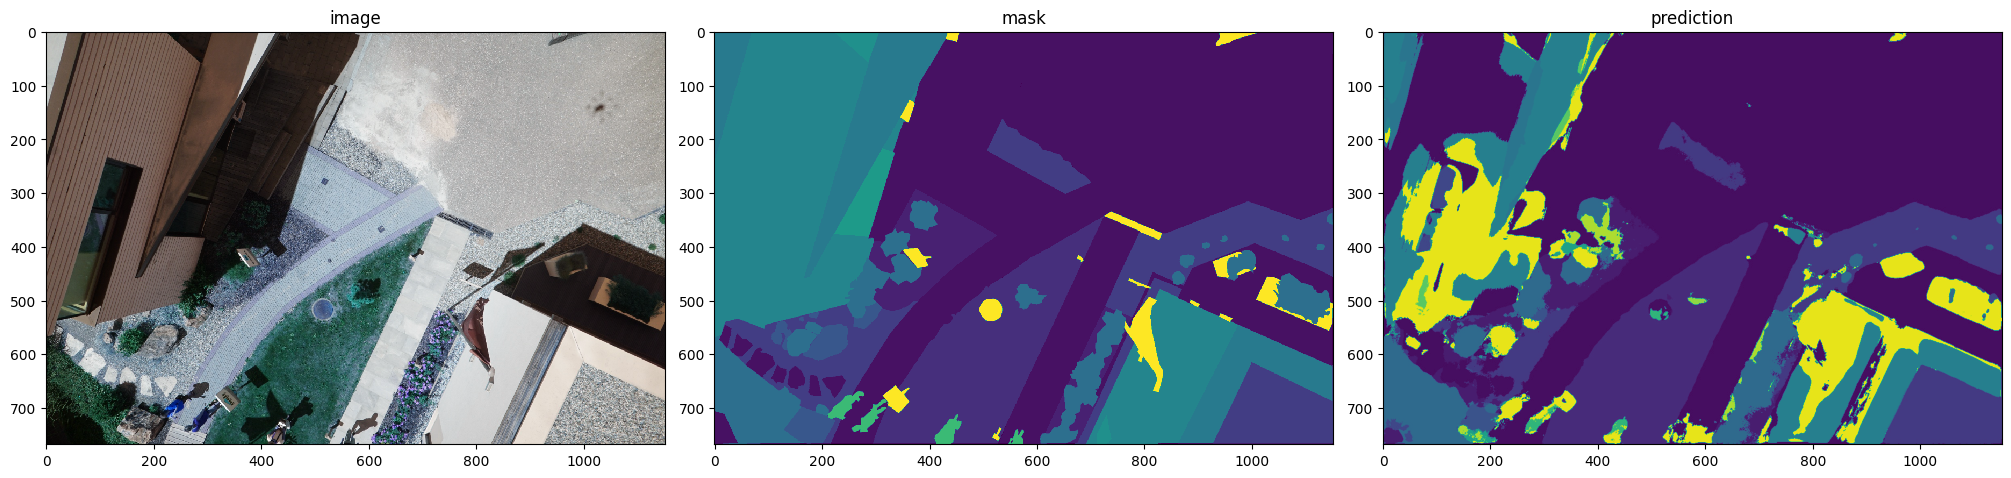

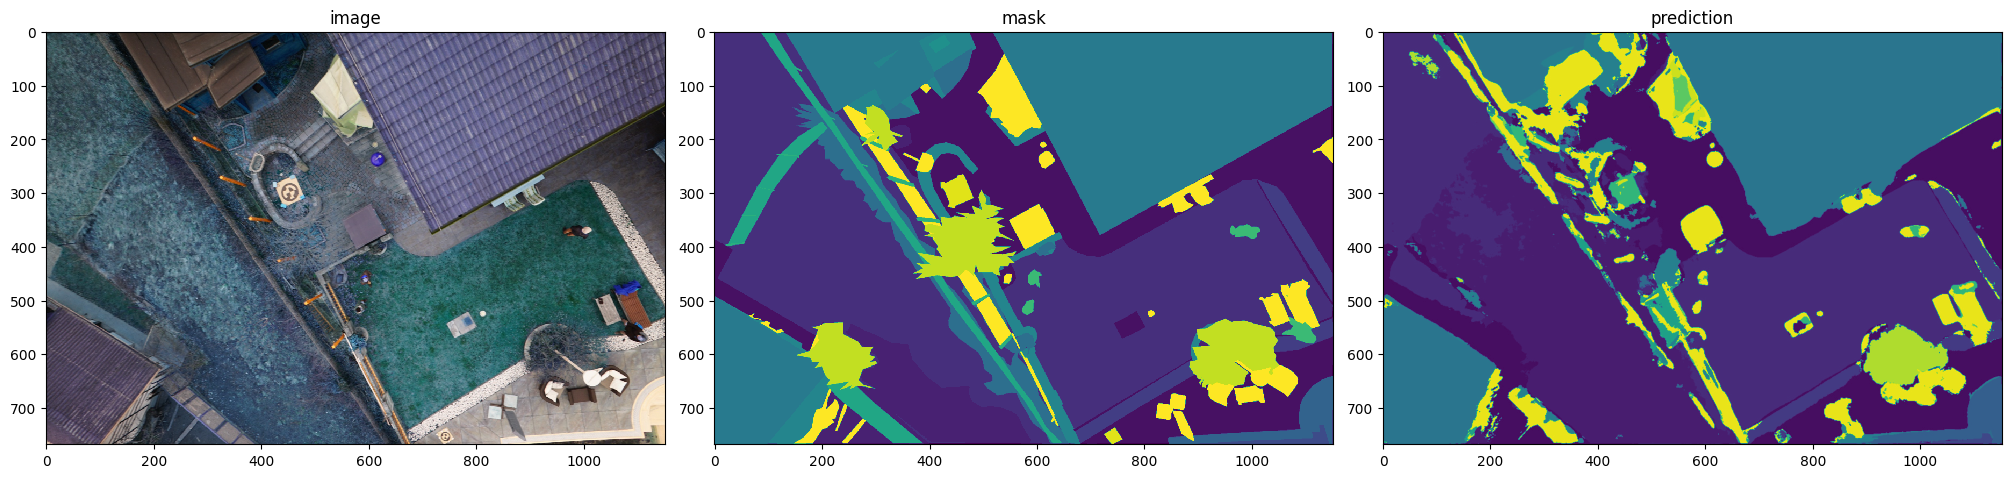

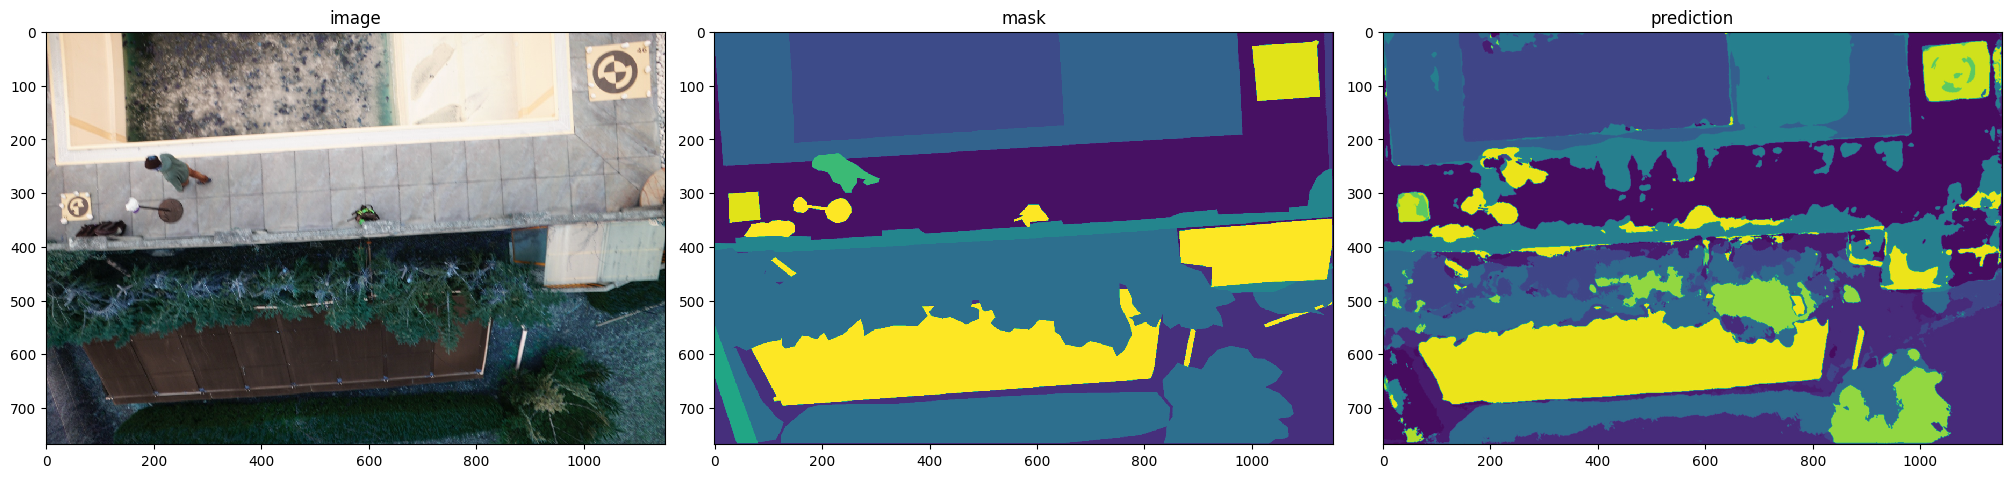

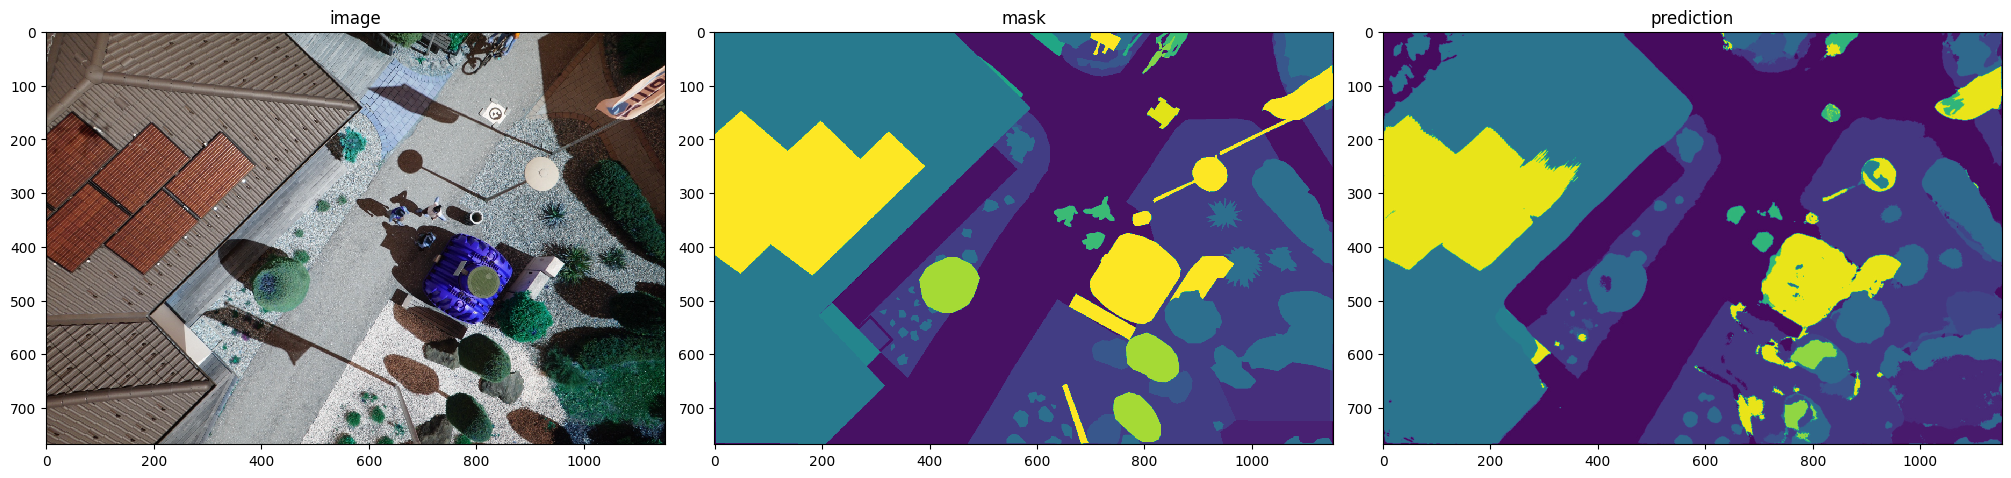

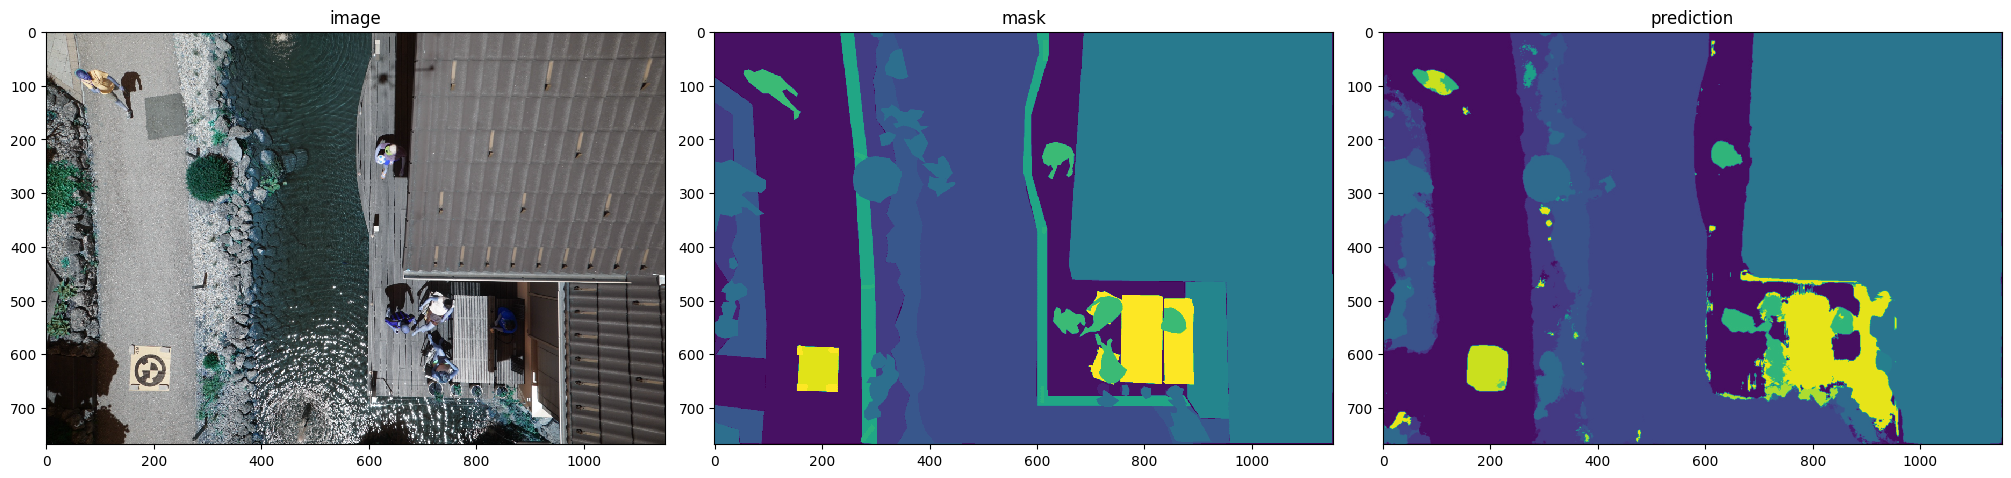

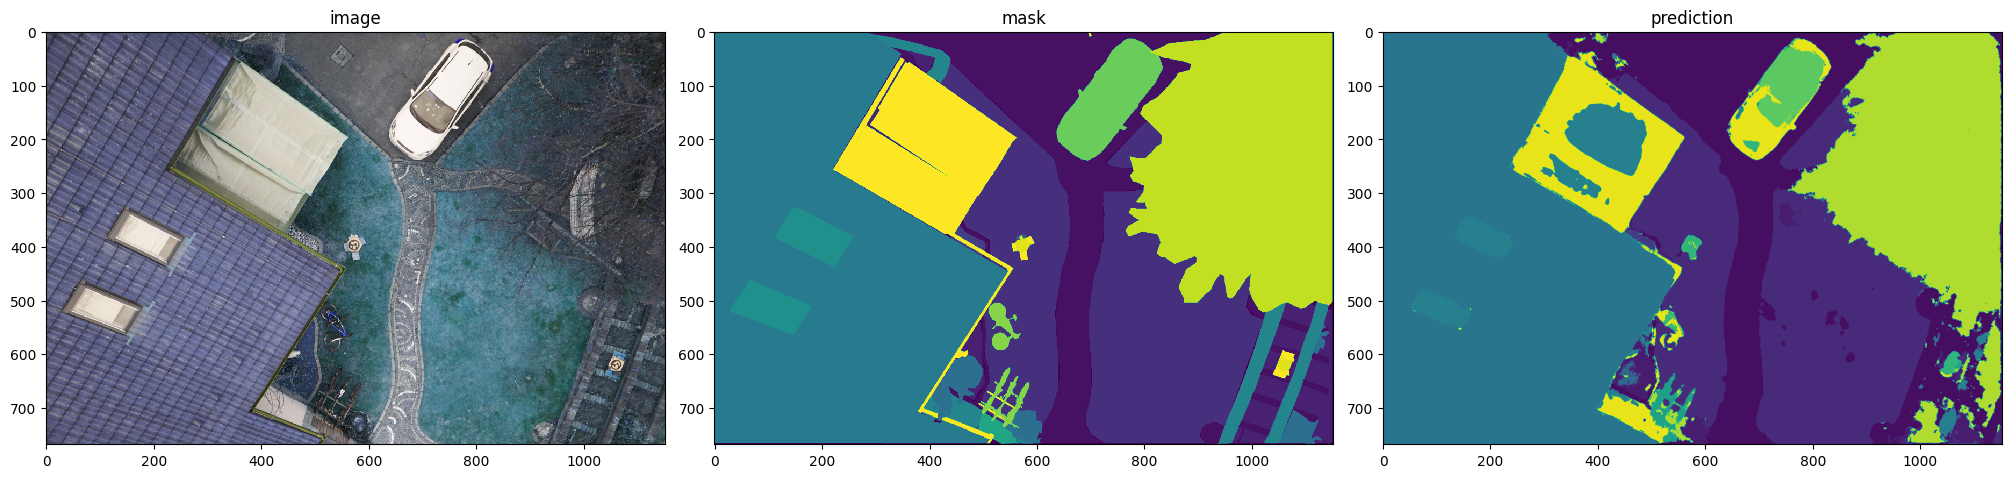

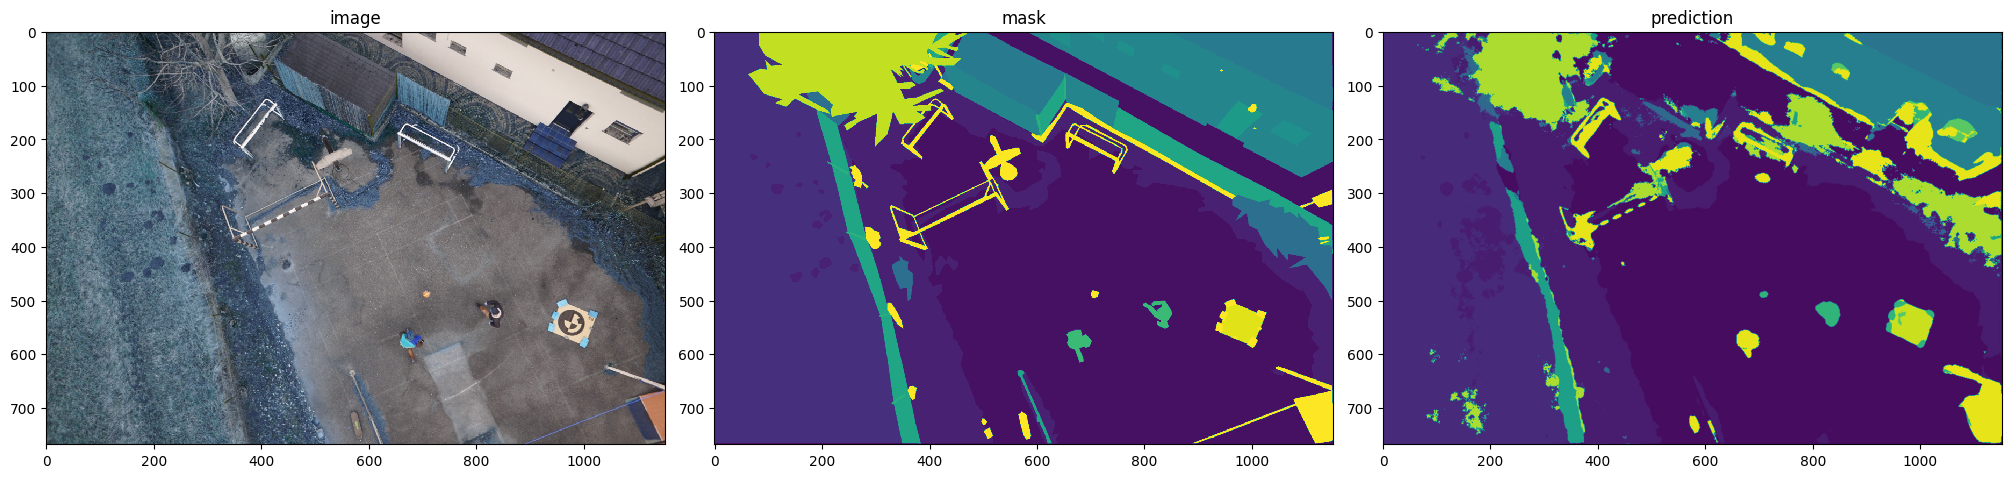

In [14]:
# Visualizing a subset of 7 images along with their corresponding masks and predicted masks to assess the accuracy of the model's predictions.
# Comparing the original image, ground truth mask, and predicted mask to visually inspect the accuracy of the segmentation predictions.

img_selection = image_list[0:7]
mask_selection = mask_list[0:7]

for img, mask in zip(img_selection, mask_selection):
    name = img.split("/")[-1]
    x = cv2.imread(img, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))

    y = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    y = cv2.resize(y, (W, H))


    p = cv2.imread(f"./results/{name}", cv2.IMREAD_GRAYSCALE)
    p = cv2.resize(p, (W, H))

    fig, axs = plt.subplots(1, 3, figsize=(20, 20), constrained_layout=True)

    axs[0].imshow(x, interpolation = 'nearest')
    axs[0].set_title('image')
    axs[0].grid(False)

    axs[1].imshow(y, interpolation = 'nearest')
    axs[1].set_title('mask')
    axs[1].grid(False)

    axs[2].imshow(p)
    axs[2].set_title('prediction')
    axs[2].grid(False)